In [80]:
%matplotlib inline
import time

# Section 1
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy

# Section 2
from scipy import signal
import scipy as sp

# Sections 4-5
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier # use Tensorflow
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix as ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Loading the data #

Load and preprocess the data: copied from notebook 4 of exercises from week 10

In [2]:
# data_path = ''
fs = 24400 # Hz

# Subjects
n_subjects = 2
subjs_info_loading = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RR15', 'TV500']},
                      'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RR15', 'TV125']}
                     }
subjs_info_final = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']},
                    'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']}
                   }
animals_labels = ['p2-t2', 'p6-t6']

def load_data_all_subjects(subjs_info_loading, subjs_info_final, fs, type_data = 'Field_Data_Neuro'):
    subjects_names = list(subjs_info_loading.keys())
    subjs_info = subjs_info_final
    all_data = {}
    print('Start loading ... \n')
    for subject in subjects_names:
        name_subj, data_struct = load_data_one_subject(subject, subjs_info_loading, fs, type_data = type_data)
        all_data[name_subj] = data_struct
        print('================== %s loaded. =================='%subject)
    return all_data


def load_data_one_subject(subject, subjs_info_loading, fs, type_data = 'Field_Data_Neuro'):
    name_subj_to_stock = subjs_info_loading[subject]['Name']
    vars_to_load = subjs_info_loading[subject]['Vars']
    data_struct = {}
    
    # file = h5py.File('data\\' + subject + '.mat','r')
    file = h5py.File(subject + '.mat','r')
    
    # To get the names of the fields after decoding ASCII
    all_field_names = get_field_names(file)

    for var in vars_to_load:
        id_field = np.where(all_field_names == var)[0]
        curr_reference_data1 = file['Vagus_Data_Stimuli'][type_data][id_field][0][0]
        curr_reference_data2 = file[curr_reference_data1][0][0]
        final_data = np.transpose(np.asarray(file[curr_reference_data2]))
        
        if var == 'TV800' or var == 'TV500' or var == 'TV125': 
            var_name = 'TVC'
        elif var == 'RR15' or var == 'RR20': 
            var_name = 'RRC'
        else:
            var_name = var
            
        data_struct[var_name] = {}
        data_struct[var_name]['Data'] = final_data
        n_time_pts = np.shape(final_data)[-1]
        data_struct[var_name]['Time_pts'] = np.linspace(0, n_time_pts/fs, n_time_pts)
        
    return name_subj_to_stock, data_struct

def get_field_names(file):
    n_fields,_ = np.shape(file['Vagus_Data_Stimuli']['stimuli_name'])
    all_field_names = []
    for field in range(n_fields):
        curr_reference_field = file['Vagus_Data_Stimuli']['stimuli_name'][field][0]
        curr_field_ASCII = file[curr_reference_field]
        curr_field = decode_ASCII(curr_field_ASCII)
        all_field_names.append(curr_field)
    return np.asarray(all_field_names)


def decode_ASCII(numbers_array):
    name = ''
    squeezed_numbers = np.squeeze(numbers_array)
    for n in squeezed_numbers:
        name += chr(n)
    return name

data = load_data_all_subjects(subjs_info_loading, subjs_info_final, fs)
print('Loading completed \n')

#print('Showing the data file:')
#for key1 in data.keys():
#    print('=========== %s ==========='%key1)
#    for key2 in data[key1].keys():
#        print('--- %s'%key2)
#        for key3 in data[key1][key2].keys():
#            print(' - %s'%key3)
#            print('Shape : ', np.shape(data[key1][key2][key3]))

def cut_all_data_to_established_duration_per_challenge(data):
    '''
    This function is a wrap-up to the function 'cut_data_one_pig_to_established_duration_per_challenge'.
    '''
    
    new_data_struct = {}
    for pig in data.keys():
        print('================== Working on Pig %s =================='%pig)
        data_curr_pig = data[pig]
        data_curr_pig_cut = cut_data_one_pig_to_established_duration_per_challenge(data_curr_pig)
        new_data_struct[pig] = data_curr_pig_cut
        
    return new_data_struct


def cut_data_one_pig_to_established_duration_per_challenge(data_one_pig):
    ''' 
    This function is used to cut the data for each challenge to the duration shown in Suppl. Table 1 in Vallone et al., 2021. 
    We take the first part of the data for each challenge (arbitrary choice). 
    '''
    new_struct = copy.deepcopy(data_one_pig)
    
    dur_baseline = 5 #min
    dur_RRC = 2 #min
    dur_TVC = 2 #min
    
    for challenge in new_struct.keys():
        data_curr_chal = new_struct[challenge]['Data']
        time_pts_curr_chal = new_struct[challenge]['Time_pts']
        t_end_sec = time_pts_curr_chal[-1]
        
        if challenge == 'Baseline': t_end_sec = dur_baseline * 60
        elif challenge == 'RRC': t_end_sec = dur_RRC * 60
        elif challenge == 'TVC': t_end_sec = dur_TVC * 60
            
#         print('Challenge %s , t_end_sec %0.3f'%(challenge, t_end_sec))
            
        id_t_end_curr_chal = find_specific_time_index(time_pts_curr_chal, t_end_sec)
        new_struct[challenge]['Data'] = data_curr_chal[:,:id_t_end_curr_chal]
        new_struct[challenge]['Time_pts'] = time_pts_curr_chal[:id_t_end_curr_chal]
    
    return new_struct

def find_specific_time_index(time_pts, t):
    t_id = np.argmin(np.abs(time_pts - t))
    return t_id

print('Start cutting data ... \n')
cut_data = cut_all_data_to_established_duration_per_challenge(data)
print('Data cutting completed \n')

Start loading ... 

================== Subject2 loaded. ==================
================== Subject21 loaded. ==================
Loading completed 

Start cutting data ... 

================== Working on Pig p2-t2 ==================
================== Working on Pig p6-t6 ==================
Data cutting completed 



Data is structured pig -> challenge -> data, time

In [3]:
print('Showing the data files:')
for key1 in cut_data.keys():
    print('=========== %s ==========='%key1)
    for key2 in cut_data[key1].keys():
        print('--- %s'%key2)
        for key3 in cut_data[key1][key2].keys():
            print(' - %s'%key3)
            print('Shape : ', np.shape(cut_data[key1][key2][key3]), ', type: ', type(cut_data[key1][key2][key3]))
            

Showing the data files:
=========== p2-t2 ===========
--- Baseline
 - Data
Shape :  (8, 7319999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (7319999,) , type:  <class 'numpy.ndarray'>
--- Angio36
 - Data
Shape :  (8, 14780415) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (14780415,) , type:  <class 'numpy.ndarray'>
--- RRC
 - Data
Shape :  (8, 2927999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (2927999,) , type:  <class 'numpy.ndarray'>
--- TVC
 - Data
Shape :  (8, 2927999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (2927999,) , type:  <class 'numpy.ndarray'>
=========== p6-t6 ===========
--- Baseline
 - Data
Shape :  (16, 7319999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (7319999,) , type:  <class 'numpy.ndarray'>
--- Angio36
 - Data
Shape :  (16, 14940159) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (14940159,) , type:  <class 'numpy.ndarray'>
--- RRC
 - Data
Shape :  (16, 2927999) , type:  <class 'numpy.ndarray'>
 - T

# 2. Preprocessing #

The paper says they use a 4-order Butterworth filter [1000, 6000] Hz. 

Note that we have fs = 24400 Hz, hence by Shannon the recorded signal can have no components above 2*fs 48000. 

Why do we bandpass at 6k Hz then???

We highpass at 1kHz to remove any forms of noise, notably due to the organism itself. 

In [4]:
f_low = 1000 # [Hz]
f_high = 6000 # [Hz]
N = 4 # order of the filter
sos = signal.butter(N, [f_low, f_high], 'bandpass', analog=False, fs=fs, output='sos')

In [5]:
def bandpass_data(data, sos):
    print('Bandpassing the data... \n')
    new_data = copy.deepcopy(data)
    for pig in data.keys():
        print('=========== %s ==========='%pig)
        for challenge in data[pig].keys():
            new_data[pig][challenge] = signal.sosfilt(sos, cut_data[pig][challenge]['Data'])
    return new_data        

Note that here we remove the 'time' field, which is not used

In [6]:
# takes ~40sec to run
data_filtered = bandpass_data(cut_data, sos)

Bandpassing the data... 

=========== p2-t2 ===========
=========== p6-t6 ===========


Sub-sampling of the signal by a factor 2: 

(Why???)

In [7]:
# takes ~20sec to run
data_subsampled = copy.deepcopy(data_filtered)
# data_subsampled = data_blank
for pig in data.keys():
    for challenge in data[pig].keys():
        data_subsampled[pig][challenge] = data_subsampled[pig][challenge][:,0:-1:2]

data_final = data_subsampled

In [30]:
with open('data_preprocessed.npy', 'wb') as f:
    np.save(f, data_final)

# 3. Perform windowing and extract features #

In [2]:
with open('data_preprocessed.npy', 'rb') as f:
    data_final = np.load(f, allow_pickle=True).item()
fs = 24400

Following this we have the following data structure: four separate sets, each set contains the four challenges, for each challenge the data

Compute features, as given in the paper. 

Note the structure used:

- compute_features computes features on the time series for a single channel, for a single challenge
- windowing_and_features generates features for a given challenge; it iterates in time to create windows, inside this loop it iterates on each channel and concatenates the result to make a feature vector [(num_features*num_channels)]; 
- data_windowing_and_features creates the features array and the labels vector by combining the features on the four challenges

Other implementation detail: it's easier to perform windowing and features computation in the same loop, because that way the dimension you gain from windowing is lost in computing features, then you don't need to use 3-d arrays

In [3]:
def compute_features(data):
    '''
    :param data: vector [timesteps]
    :return features: vector of features for that time series [9]
    '''
    mean = np.mean(data)
    variance = np.var(data)
    skew = sp.stats.skew(data)
    kurtosis = sp.stats.kurtosis(data)
    std = np.std(data)
    mav = np.mean(np.absolute(data))
    max = np.amax(data)
    amp = 0 #
    wl = 0  #
    pow = np.sqrt(np.mean(data ** 2))

    for i in range(len(data) - 1):
        if abs(data[i + 1] - data[i]) >= std:
            amp += 1
        wl += abs(data[i + 1] - data[i])
    
    features = np.array([mean, variance, skew, kurtosis, mav, max, amp, wl, pow])
    return features

def windowing_and_features(data, ws, wo):
    '''
    :param data: ndarray [channels x timesteps]
    :return: ndarray [windows x (features*channels)]
    '''
    windowStep_n = ws - wo
    num_windows = int((data.shape[1]-ws)/windowStep_n)
    num_features = 9
    num_channels = data.shape[0]
    features = np.empty((num_windows, num_features*num_channels))
    for i in range(num_windows): # iterate over windows
        for j in range(num_channels): # iterate over channels
            window = data[j, i*windowStep_n:i*windowStep_n+ws]
            features_channel = compute_features(window)
            features[i,j*num_features:(j+1)*num_features] = features_channel
    return features

# def data_windowing_and_features(data, ws, wo):
#     '''
#     :param data: dictionary with four keys (challenges), each challenge contains an ndarray [channels x timesteps]
#     :return features: ndarray [folds x (challenges*windows) x (features*channels)]
#     :return labels: vector [folds x (challenges*windows)]
#     '''

#     ws = int(ws)
#     wo = int(wo)

#     kf = KFold(10)
#     num_features = 9
#     num_channels = data[list(data.keys())[0]].shape[0] # height of the first dict element

#     train_features = np.array([])
#     train_labels = np.array([])
#     test_features = np.array([])
#     test_labels = np.array([])

#     for current_label, (challenge, values) in enumerate(data.items()):
#         print(challenge)
#         challenge_train_features = np.array([])
#         challenge_train_labels = np.array([])
#         challenge_test_features = np.array([])
#         challenge_test_labels = np.array([])
#         for fold_index, (train_index, test_index) in enumerate(kf.split(values.T)):
#             print(train_index[0])
#             print(test_index[0])
#             #print("Train:", train_index[0],":",train_index[-1], "- Test:", test_index[0],":",test_index[-1])
#             train_data = values[:,train_index]
#             test_data = values[:,test_index]
#             current_train_features = windowing_and_features(train_data, ws, wo)
#             current_train_labels = current_label * np.ones(current_train_features.shape[0])
#             current_test_features = windowing_and_features(test_data, ws, wo)
#             current_test_labels = current_label * np.ones(current_test_features.shape[0])
#             # print(train_data.shape)
#             # print(test_data.shape)
#             # print(current_train_features.shape)
#             # print(current_train_labels.shape)
#             # print(current_test_features.shape)
#             # print(current_test_labels.shape)
#             challenge_train_features = np.dstack((challenge_train_features, current_train_features)) if challenge_train_features.size else current_train_features
#             challenge_train_labels = np.vstack((challenge_train_labels, current_train_labels)) if challenge_train_labels.size else current_train_labels
#             challenge_test_features = np.dstack((challenge_test_features, current_test_features)) if challenge_test_features.size else current_test_features
#             challenge_test_labels = np.vstack((challenge_test_labels, current_test_labels)) if challenge_test_labels.size else current_test_labels

#         train_features = np.vstack((train_features, challenge_train_features)) if train_features.size else challenge_train_features
#         train_labels = np.vstack((train_labels, challenge_train_labels)) if train_labels.size else challenge_train_labels
#         test_features = np.vstack((test_features, challenge_test_features)) if test_features.size else challenge_test_features
#         test_labels = np.vstack((test_labels, challenge_test_labels)) if test_labels.size else challenge_test_labels

#     return train_features, train_labels, test_features, test_labels

def data_windowing_and_features(data, ws, wo):
    '''
    :param data: dictionary with four keys (challenges), each challenge contains an ndarray [channels x timesteps]
    :return features: ndarray [folds x (challenges*windows) x (features*channels)]
    :return labels: vector [folds x (challenges*windows)]
    '''

    ws = int(ws)
    wo = int(wo)

    num_features = 9
    num_channels = data[list(data.keys())[0]].shape[0] # height of the first dict element

    train_features = np.array([])
    train_labels = np.array([])
    test_features = np.array([])
    test_labels = np.array([])

    for current_label, (challenge, values) in enumerate(data.items()):
        print(challenge)
        # challenge_train_features = np.array([])
        # challenge_train_labels = np.array([])
        # challenge_test_features = np.array([])
        # challenge_test_labels = np.array([])
        # for fold_index, (train_index, test_index) in enumerate(kf.split(values.T)):
        #     print(train_index[0])
        #     print(test_index[0])
        #     #print("Train:", train_index[0],":",train_index[-1], "- Test:", test_index[0],":",test_index[-1])
        #     train_data = values[:,train_index]
        #     test_data = values[:,test_index]
        current_train_features = windowing_and_features(values, ws, wo)
        current_train_labels = current_label * np.ones(current_train_features.shape[0])
        current_test_features = windowing_and_features(values, ws, 0)
        current_test_labels = current_label * np.ones(current_test_features.shape[0])
        #     # print(train_data.shape)
        #     # print(test_data.shape)
        print("current_train_features", current_train_features.shape)
        print("current_train_label", current_train_labels.shape)
        print("current_test_features", current_test_features.shape)
        print("current_test_labels", current_test_labels.shape)
        #     challenge_train_features = np.dstack((challenge_train_features, current_train_features)) if challenge_train_features.size else current_train_features
        #     challenge_train_labels = np.vstack((challenge_train_labels, current_train_labels)) if challenge_train_labels.size else current_train_labels
        #     challenge_test_features = np.dstack((challenge_test_features, current_test_features)) if challenge_test_features.size else current_test_features
        #     challenge_test_labels = np.vstack((challenge_test_labels, current_test_labels)) if challenge_test_labels.size else current_test_labels

        train_features = np.vstack((train_features, current_train_features)) if train_features.size else current_train_features
        train_labels = np.concatenate((train_labels, current_train_labels)) if train_labels.size else current_train_labels
        test_features = np.vstack((test_features, current_test_features)) if test_features.size else current_test_features
        test_labels = np.concatenate((test_labels, current_test_labels)) if test_labels.size else current_test_labels
        print("train_features", train_features.shape)
        print("train_labels", train_labels.shape)
        print("test_features", test_features.shape)
        print("test_labels", test_labels.shape)

    return train_features, train_labels, test_features, test_labels

In [4]:
window_sizes_t = np.linspace(0.05, 1, round(1/0.05)) #[s]
window_sizes_n = np.around(window_sizes_t * fs) #[timesteps]
window_overlaps_t = 0.2 * window_sizes_t #[s]
window_overlaps_n = np.around(window_overlaps_t * fs)

In [ ]:
#FOR TESTING
ws = window_sizes_n[0]
wo = window_overlaps_n[0]
print("Ws:", ws, "| Wo:", wo)
train_features, train_labels, test_features, test_labels = data_windowing_and_features(data_final['p2-t2'], ws, wo)
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

In [6]:
data_feature = {}
for pig, pig_data in data_final.items():
	print("Pig:", pig)
	data_feature[pig] = {}
	for ws, wo in zip(window_sizes_n, window_overlaps_n):
		data_feature[pig][ws] = {}
		print("Ws:", ws, "| Wo:", wo)
		#Extract windows and features
		train_features, train_labels, test_features, test_labels = data_windowing_and_features(pig_data, ws, wo)
		data_feature[pig][ws]["x_mean"] = train_features.mean(axis=0)
		data_feature[pig][ws]["x_std"] = train_features.std(axis=0)
		data_feature[pig][ws]["train_x_raw"] = train_features
		data_feature[pig][ws]["train_x"] = (train_features - data_feature[pig][ws]["x_mean"]) / data_feature[pig][ws]["x_std"]
		data_feature[pig][ws]["train_y"] = train_labels
		data_feature[pig][ws]["test_x_raw"] = test_features
		data_feature[pig][ws]["test_x"] = (test_features - data_feature[pig][ws]["x_mean"]) / data_feature[pig][ws]["x_std"]
		data_feature[pig][ws]["test_y"] = test_labels
		# print(data_feature[pig][ws]["train_x"].mean(axis=0))
		# print(data_feature[pig][ws]["train_x"].std(axis=0))
		# print(train_features.shape)
		# print(train_labels.shape)
		# print(test_features.shape)
		# print(test_labels.shape)

Pig: p2-t2
Ws: 1220.0 | Wo: 244.0
Baseline
current_train_features (3748, 72)
current_train_label (3748,)
current_test_features (2998, 72)
current_test_labels (2998,)
train_features (3748, 72)
train_labels (3748,)
test_features (2998, 72)
test_labels (2998,)
Angio36
current_train_features (7570, 72)
current_train_label (7570,)
current_test_features (6056, 72)
current_test_labels (6056,)
train_features (11318, 72)
train_labels (11318,)
test_features (9054, 72)
test_labels (9054,)
RRC
current_train_features (1498, 72)
current_train_label (1498,)
current_test_features (1198, 72)
current_test_labels (1198,)
train_features (12816, 72)
train_labels (12816,)
test_features (10252, 72)
test_labels (10252,)
TVC
current_train_features (1498, 72)
current_train_label (1498,)
current_test_features (1198, 72)
current_test_labels (1198,)
train_features (14314, 72)
train_labels (14314,)
test_features (11450, 72)
test_labels (11450,)
Ws: 2440.0 | Wo: 488.0
Baseline
current_train_features (1873, 72)
curre

In [7]:
# with open('data_features.npy', 'wb') as f:
#     np.save(f, data_feature)

# 4. Perform classification #

In [13]:
with open('data_features.npy', 'rb') as f:
    data_feature = np.load(f, allow_pickle=True).item()

#Recreate variables without running previous cells
fs = 24400
window_sizes_t = np.linspace(0.05, 1, round(1/0.05)) #[s]
window_sizes_n = np.around(window_sizes_t * fs) #[timesteps]
window_overlaps_t = 0.2 * window_sizes_t #[s]
window_overlaps_n = np.around(window_overlaps_t * fs)

In [16]:
classifiers_list = [RandomForestClassifier, KNeighborsClassifier, SVC, MLPClassifier]
# classifiers_list = [RandomForestClassifier]
parameters=	{'RandomForestClassifier': 	{'n_estimators': [50,100,200],#[50, 100, 200, 400],
										 'max_depth': [5,10]},#[5, 10, 20]},
			 'KNeighborsClassifier':	{'n_neighbors': [3, 5, 7, 9, 11, 13]},
			 'SVC':						{'kernel': ['rbf', 'sigmoid'],
			 							 'C': [0.01, 0.1, 1]},
			 'MLPClassifier':			{'hidden_layer_sizes': [[128,128,128,128], [128,512,512,128], [128,256,512,512]],
			 							 'batch_size': [128],
										 'max_iter': [30]}
			}
kf = StratifiedKFold(10)

results = {}
for pig, pig_data in data_feature.items():
	results[pig] = {}
	print("Pig:", pig)
	for ws, wo in zip(window_sizes_n, window_overlaps_n):
		results[pig][ws] = {}
		print("Ws:", ws, "| Wo:", wo)
		train_data = data_feature[pig][ws]["train_x"]
		train_labels = data_feature[pig][ws]["train_y"]
		test_data = data_feature[pig][ws]["test_x"]
		test_labels = data_feature[pig][ws]["test_y"]

		test_splits = list(kf.split(test_data, test_labels))
		for fold_index, (train_index, _) in enumerate(kf.split(train_data, train_labels)):
			print("Fold:", fold_index)
			results[pig][ws][fold_index] = {}
			test_index = test_splits[fold_index][1] #Second element contains test index
			#Outer cross validation
			train_data_split = train_data[train_index]
			train_labels_split = train_labels[train_index]
			test_data_split = test_data[test_index]
			test_labels_split = test_labels[test_index]
			for classifier_class in classifiers_list:
				print("Classifier:", classifier_class.__name__)
				classifier = classifier_class()
				results[pig][ws][fold_index][classifier_class.__name__] = {}
				#Grid search training with cross validation
				best_classifier = GridSearchCV(classifier, parameters[classifier_class.__name__], scoring='balanced_accuracy', verbose=2, n_jobs=-1)
				best_classifier.fit(train_data_split, train_labels_split)
				results[pig][ws][fold_index][classifier_class.__name__]["gridsearch_res"] = best_classifier.cv_results_
				results[pig][ws][fold_index][classifier_class.__name__]["best_params"] = best_classifier.best_params_
				if classifier_class.__name__ == "RandomForestClassifier":
					results[pig][ws][fold_index][classifier_class.__name__]["feature_importances"] = best_classifier.best_estimator_.feature_importances_
					# print(results[pig][ws][fold_index][classifier_class.__name__]["feature_importances"])
				#Final model validation
				results[pig][ws][fold_index][classifier_class.__name__]["test_y"] = test_labels_split
				validation_results = best_classifier.predict(test_data_split)
				results[pig][ws][fold_index][classifier_class.__name__]["validation_output"] = validation_results
				validation_score = balanced_accuracy_score(test_labels_split, validation_results)
				results[pig][ws][fold_index][classifier_class.__name__]["validation_score"] = validation_score
				print(validation_score)



Pig: p2-t2
Ws: 1220.0 | Wo: 244.0
Fold: 0
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 1
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 2
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 3
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 4
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 5
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 6
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 7
Classifier: RandomForestClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: MLPClassifier
Fold: 8
Classifier: Ra

In [18]:
# with open('results_2.npy', 'wb') as f:
#     np.save(f, results)

In [14]:
with open('results_2.npy', 'rb') as f:
    results = np.load(f, allow_pickle=True).item()

# 5. Make Graphs # 

In [ ]:
# read in results
# data in the format: Pig > window size > fold > classifier > {validation score, feature importances}

classifiers_list = [RandomForestClassifier, KNeighborsClassifier, SVC, MLPClassifier]

for pig, pig_data in results.items():
	for ws, wo in zip(window_sizes_n, window_overlaps_n):
		for fold_index in range(10):
			for classifier_class in classifiers_list:
				curr_item = results[pig][ws][fold_index][classifier_class.__name__]
				validation_score = curr_item['validation_score']


Balanced Accuracy Graphs

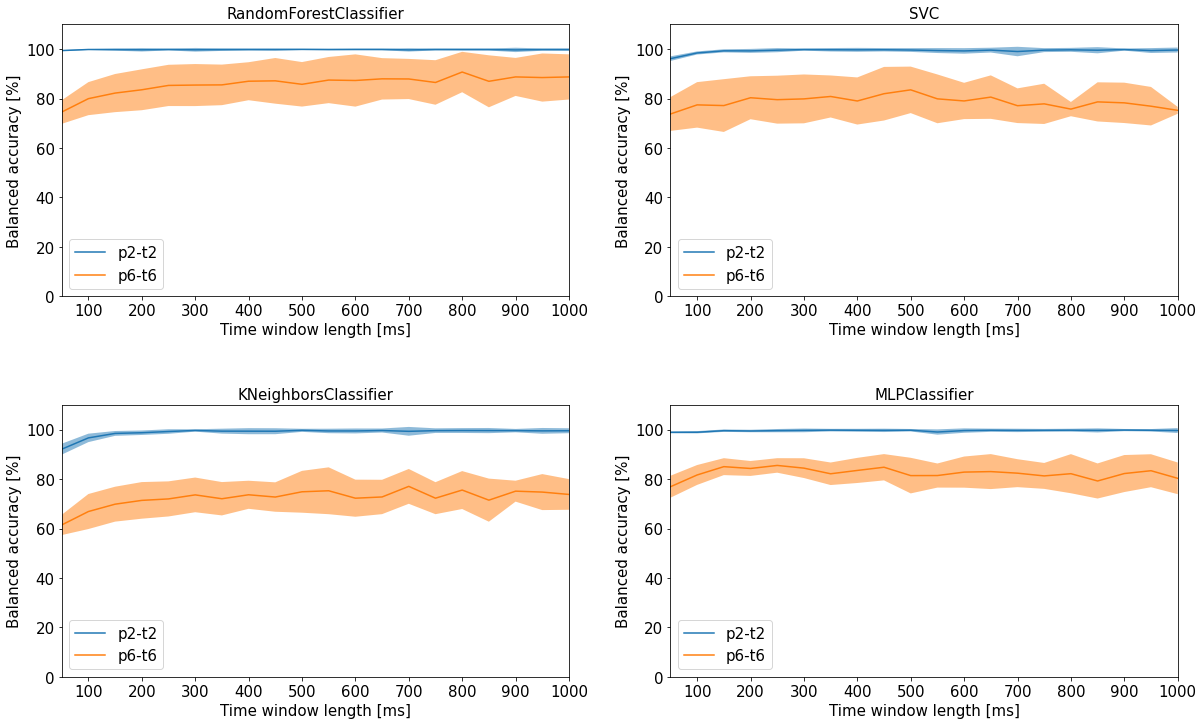

In [198]:
classifiers_list = [RandomForestClassifier, KNeighborsClassifier, SVC, MLPClassifier]
fs = 24400
window_sizes_t = np.linspace(0.05, 1, round(1/0.05)) #[s]
window_sizes_n = np.around(window_sizes_t * fs) #[timesteps]
window_overlaps_t = 0.2 * window_sizes_t #[s]
window_overlaps_n = np.around(window_overlaps_t * fs)

fig, ax = plt.subplots(2,2,figsize=(20,12))
n = 15 # fontsize

for i, classifier_class in enumerate(classifiers_list):
	ax[i%2][i//2].set_ylim([0,110])
	ax[i%2][i//2].set_xlim([50,1000])
	ax[i%2][i//2].set_xlabel('Time window length [ms]', fontsize=n)
	ax[i%2][i//2].set_xticks(np.arange(100, 1100, step=100))
	ax[i%2][i//2].set_ylabel('Balanced accuracy [%]', fontsize=n)
	ax[i%2][i//2].set_title(classifier_class.__name__, fontsize=n)
	for pig, pig_data in results.items():
		bac_windows = np.empty((2,0))
		for ws, wo in zip(window_sizes_n, window_overlaps_n):
			bacs = np.empty(10)
			for fold_index in range(10):
				bacs[fold_index] = results[pig][ws][fold_index][classifier_class.__name__]['validation_score']*100
			mean_ws = np.mean(bacs)
			std_ws = np.std(bacs)
			bac_windows = np.append(bac_windows, np.array([[mean_ws],[std_ws]]), axis = 1)
		ax[i%2][i//2].plot(window_sizes_t*1000, bac_windows[0,:], label=pig)
		ax[i%2][i//2].fill_between(window_sizes_t*1000, bac_windows[0,:]-bac_windows[1,:], bac_windows[0,:]+bac_windows[1,:], alpha=0.5)
		ax[i%2][i//2].legend(fontsize=n)
plt.subplots_adjust(hspace=0.4)
plt.show()

Confusion Matrices

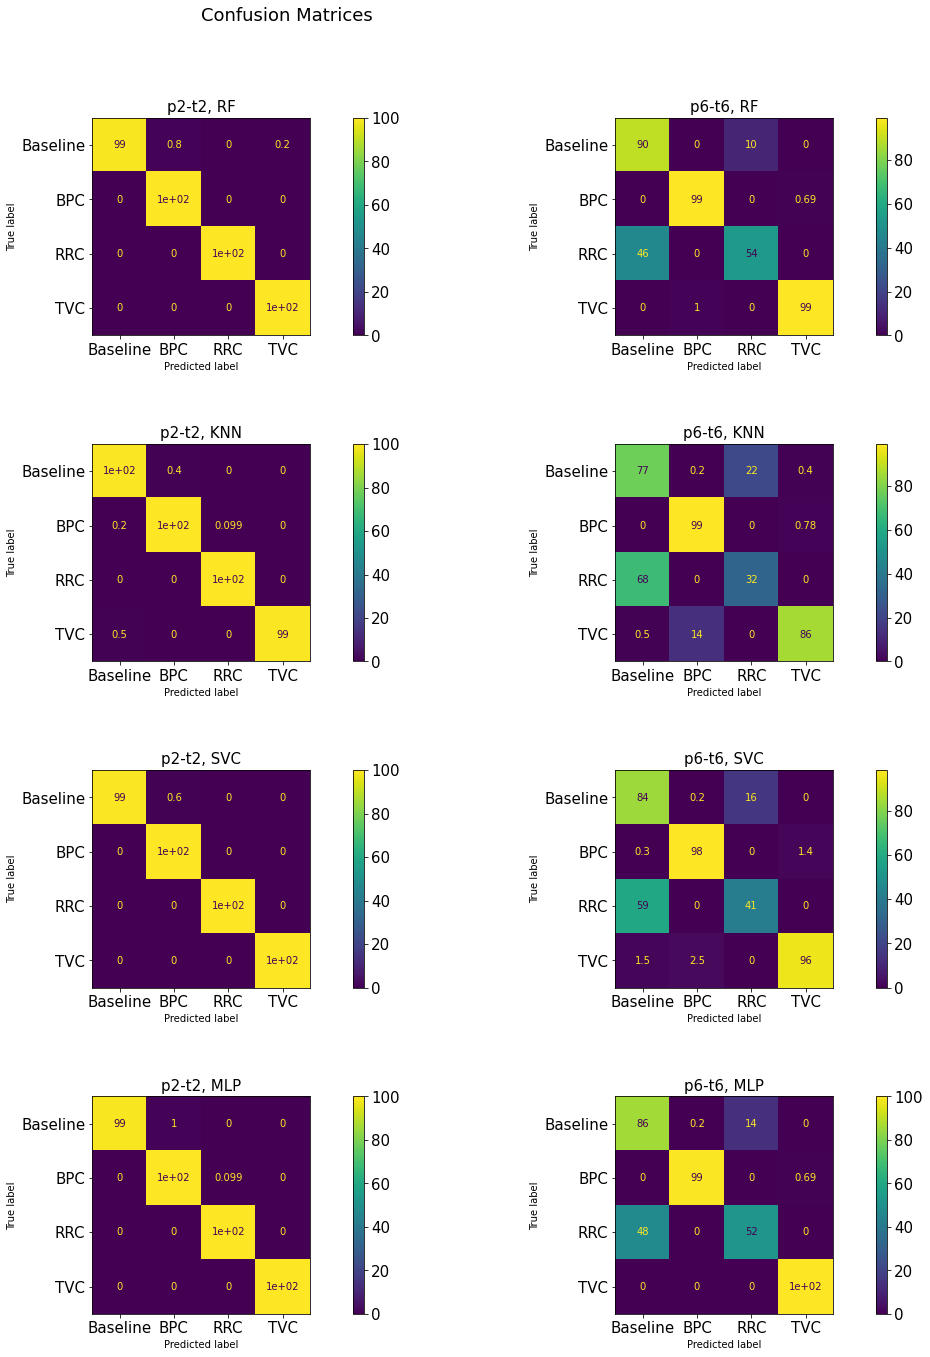

In [196]:
plt.figure(figsize=(25,22))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Confusion Matrices", fontsize=18, y=0.95)
n = 1
classifier = ["RF", "RF", "KNN", "KNN", "SVC", "SVC", "MLP", "MLP"]
labels = ["Baseline", "BPC", "RRC", "TVC"]

for classifier_class in classifiers_list:
	for pig, pig_data in results.items():
		avg_confusion = np.zeros((4,4))
		for fold_index in range(10):
			curr_item = results[pig][0.3*fs][fold_index][classifier_class.__name__]
			y_pred = curr_item["validation_output"]
			y_true = curr_item["test_y"]
			confusion = ConfusionMatrix(y_true, y_pred, normalize='true')
			avg_confusion += confusion
		avg_confusion = avg_confusion / 10 * 100
		disp = ConfusionMatrixDisplay(avg_confusion, display_labels=labels)

		ax = plt.subplot(4, 2, n)
		disp.plot(ax=ax)
		ax.set_title("{}, {}".format(pig, classifier[n-1]), fontsize=15)

		n += 1

plt.subplots_adjust(wspace=-0.4)
plt.show()
		

Feature Importance Graph

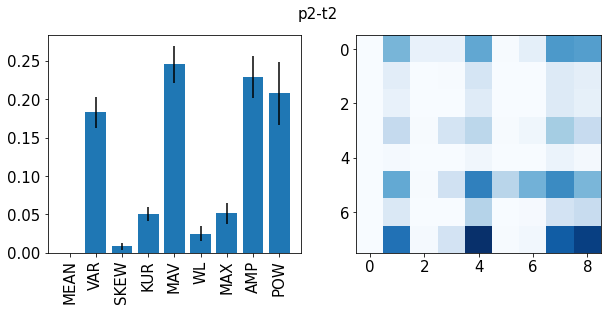

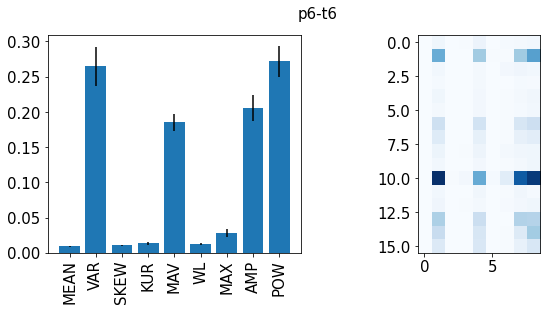

No handles with labels found to put in legend.


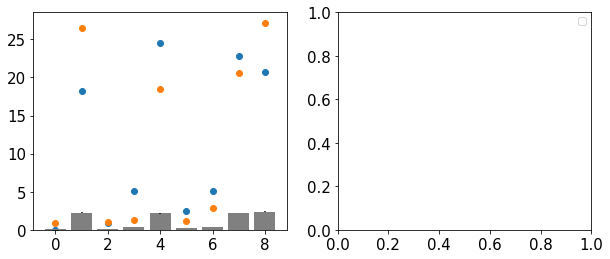

In [202]:
pig_importances = np.empty((2,9))
i=0
for pig, pig_data in results.items():
	#plt.figure(i, figsize=(8, 6), dpi=80)
	fig, ax = plt.subplots(1,2,figsize=(10,4))
	importances = np.empty((10,9))
	n_channels = int(results[pig][0.3*fs][fold_index]["RandomForestClassifier"]['feature_importances'].shape[0]/9)
	matrix_importances = np.empty((10,n_channels,9))
	for fold_index in range(10):
		matrix_importances[fold_index, :, :] = results[pig][0.3*fs][fold_index]["RandomForestClassifier"]['feature_importances'].reshape((-1,9))
		importances[fold_index,:] = matrix_importances[fold_index, :, :].sum(axis=0)
		
	matrix_importances = matrix_importances.mean(axis=0)
	ax[1].imshow(matrix_importances,  cmap='Blues')
	mean_importances = np.mean(importances, axis=0)
	std_importances = np.std(importances, axis=0)
	pig_importances[i,:] = mean_importances
	ax[0].bar(np.arange(9), mean_importances, yerr=std_importances)
	plt.suptitle(pig, fontsize=15)
	ticks = ['MEAN', 'VAR', 'SKEW', 'KUR', 'MAV', 'WL', 'MAX', 'AMP', 'POW']
	ax[0].set_xticks(range(len(ticks)))
	ax[0].set_xticklabels(ticks, rotation=90)
	plt.show()
	i+=1

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].bar(np.arange(9), np.mean(pig_importances, axis=0)*10, yerr = np.std(pig_importances, axis=0), color = 'grey')
ax[0].scatter(np.arange(9), pig_importances[0,:]*100, label='p2-t2')
ax[0].scatter(np.arange(9), pig_importances[1,:]*100, label='p6-t6')
plt.legend()
plt.show()

Model Performances (boxplot)

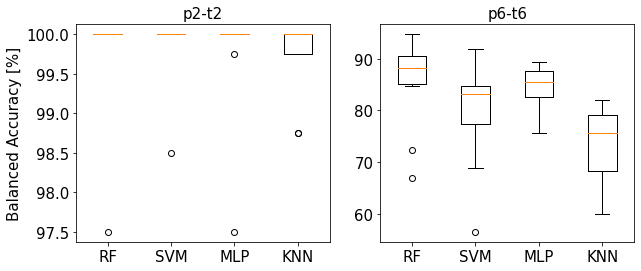

In [195]:
# data in the format: Pig > window size > fold > classifier > {validation score, feature importances}

class_dict = {"RandomForestClassifier":"RF", "SVC":"SVM", "MLPClassifier":"MLP", "KNeighborsClassifier":"KNN"}
fig, ax = plt.subplots(1,2,figsize=(10,4))
i = 0
for pig, pig_data in results.items():
    classifiers = ["RandomForestClassifier", "SVC", "MLPClassifier", "KNeighborsClassifier"]
    bp_data = []
    # print(f"pig {pig}")
    for c in classifiers:
        class_data = []
        for fold, fold_data in pig_data[0.3*fs].items(): # use data from window size 300 ms
            class_data.extend([fold_data[c]['validation_score']*100])
        bp_data.append(class_data)
        # print(f"class {c} data {class_data}")
    # print(f"pd_data {bp_data}")
    ax[i].boxplot(bp_data, labels = [class_dict[c] for c in classifiers])
    ax[i].set_title(f'{pig}', fontsize=15)
    i += 1
ax[0].set_ylabel('Balanced Accuracy [%]', fontsize=15)
# plt.subplots_adjust(hspace=0.4)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.show()
    

Grand Median Performance